<a href="https://colab.research.google.com/github/ShruthiVidya-git/Prediction-of-Biological-Age-and-Mortality/blob/main/AutoEncoder_CS760.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
from pandas.compat.numpy.function import validate_expanding_func
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Conv1D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv1DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import MeanSquaredError
from keras.regularizers import l2

from google.colab import drive
drive.mount('/content/drive/')

tf.compat.v1.disable_eager_execution()
plt.style.use('ggplot')



Mounted at /content/drive/


## Convoultional VAE

In [ ]:
class Convolutional_VAE:
    """
    Variational Autoencoder - a Deep Convolutional VAE architecture with
    mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim,
                 age_true):
        self.input_shape = input_shape 
        self.conv_filters = conv_filters 
        self.conv_kernels = conv_kernels 
        self.conv_strides = conv_strides 
        self.latent_space_dim = latent_space_dim 

        self.reconstruction_loss_weight = 1000
        self.prediction_age_loss_weight = 20000
        self.encoded_vec = None
        self.age_true = age_true
        #self.age_true = None
        #self.pred_age_weights = None
        #self.latent_point = None

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build() # build all the parts of the autoencoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()
        tf.keras.utils.plot_model(self.encoder, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)
        tf.keras.utils.plot_model(self.decoder, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)
        tf.keras.utils.plot_model(self.model, to_file='vae_plot.png', show_shapes=True, show_layer_names=True)

    def compile(self, learning_rate=0.0001):
        # Define optimizer and loss functions to compile autoencoder
        #optimizer = Adam(learning_rate=learning_rate)
        
        # mse loss is used for vanila AE - instead we add the defined combined loss for VAE
        #mse_loss = MeanSquaredError()
        #self.model.compile(optimizer=optimizer, loss=mse_loss)

        self.model.compile(optimizer='adam',
                           loss=self._calculate_combined_loss)
        
        #self.model.add_metric(self._calculate_reconstruction_loss, name='Reconstruction Loss')
        #self.model.add_metric(self._calculate_kl_loss, name='KL Divergence Loss')
        #self.model.add_metric(self._calculate_predicted_age_loss, name='Predicted Age Loss')
        
    def train(self, X_train, batch_size, num_epochs):#, age):
        #self.age_true = age
        #print(self.age_true[0:5])
        self.model.fit(X_train,
                       X_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)
        

    """Helper functions to save the autoencoder parameters and weight and load it back"""

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, vectors):
        latent_representations = self.encoder.predict(vectors)
        reconstructed_vectors = self.decoder.predict(latent_representations)
        return reconstructed_vectors, latent_representations

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()
    

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

        
    """Create helper function for defining loss for VAE"""

    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        pred_age_loss = self._calculate_predicted_age_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss + kl_loss + pred_age_loss * self.prediction_age_loss_weight 
        return combined_loss

    # we are not using the target and predicted variables - it's defined here coz Keras expects this to be th earguments in any loss fiunction
    # most of the functions are used from Keras Backend
    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis=[1, 2])
        return reconstruction_loss
    
    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) - K.exp(self.log_variance))#, axis=1)
        #print(self.log_variance)
        #print(self.mu)
        return kl_loss
    
    def _calculate_predicted_age_loss(self, y_target, y_predicted):

        print(self.predict_age)
        #print(self.latent_point)
        print(self.age_true)
        print("\n\n\n")
        error = self.age_true - self.predict_age
        predicted_age_loss = K.mean(K.square(error))#, axis=[1, 2])
        return predicted_age_loss
    
    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim,
            self.age_true
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    """ Build helper functions for Encoder """

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder") # Create a encoder placeholder to build the AE

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input") # Input layer for AE, with input_shape

    def _add_conv_layers(self, encoder_input):
        # Create Convolutional layers in AE for each of the convolutional layers
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        # Convolutional layer with Conv2D block having the filter/ stride/ kernel given as input + activation as ReLU and Batch Normalization
        layer_number = layer_index + 1
        conv_layer = Conv1D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        # Flatten the inputs so far, and add bottleneck and use Guassian sampling to get a point in the latent space + Dense Layer
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        '''
        # For Vanila AE
        x = Dense(self.latent_space_dim, name="encoder_output")(x)
        '''

        # for Variational AE - Sample the latent space to lie on a multivariate normal distribution
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,name="log_variance")(x)

        
        # Inner Python function definition to return the sampled datapoint to lie in the distribution
        def sample_point_from_normal_distribution(args):
            #mu, log_variance,pred_age_weights = args
            mu, log_variance = args
            # Epsilon from a standard normal distribution
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                      stddev=1.)
            

            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            self.latent_point = sampled_point
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution,
                   name="encoder_output")([self.mu, self.log_variance])
        
        # for custom age prediction
        self.predict_age = tf.slice(x,[0,0],[1,1])

        return x
    
    """ Build helper functions for Decoder """

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) 
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer) 

    def _add_conv_transpose_layers(self, x):
        # Mirror the conv layers to create transpose convolutional layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv1DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv1DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_autoencoder(self):
        # function to build then entire encoder and decoder together
        model_input = self._model_input
        #self.encoded_vec = self.encoder(model_input)
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    #def _get_encoded_vector(self):
        #return self.encoded_vec

if __name__ == "__main__":
    variational_conv_autoencoder = Convolutional_VAE(
        input_shape=(10, 1),
        conv_filters=(32, 32, 32, 16),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 1, 1),
        latent_space_dim=4,
        age_true=[]
    )
    variational_conv_autoencoder.summary()
    


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 10, 1)]      0           []                               
                                                                                                  
 encoder_conv_layer_1 (Conv1D)  (None, 10, 32)       128         ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ReLU)          (None, 10, 32)       0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 10, 32)      128         ['encoder_relu_1[0][0]']         
 on)                                                                                        

In [ ]:
'''
pred_age = latent_representations[:,0]
plt.scatter(np.reshape(scaler.inverse_transform(y),-1),np.reshape(scaler.inverse_transform(np.expand_dims(pred_age,-1)),-1))
np.mean((np.reshape(scaler.inverse_transform(y),-1) - np.reshape(scaler.inverse_transform(np.expand_dims(pred_age,-1)),-1))**2)
'''

'\npred_age = latent_representations[:,0]\nplt.scatter(np.reshape(scaler.inverse_transform(y),-1),np.reshape(scaler.inverse_transform(np.expand_dims(pred_age,-1)),-1))\nnp.mean((np.reshape(scaler.inverse_transform(y),-1) - np.reshape(scaler.inverse_transform(np.expand_dims(pred_age,-1)),-1))**2)\n'

## Dense VAE

In [ ]:

class Desnse_AE:
    """
    This class consists of all the modules required to create and fit a 
    stacked Dense Variational Autoencoder to get latent space information from CT Data
    """

    def __init__(self,
                 input_shape,
                 num_neurons,
                 latent_space_dim,
                 age_true):
        self.input_shape = input_shape # 10,1
        self.num_neurons = num_neurons # [64,32,16,8]
        self.latent_space_dim = latent_space_dim # 2

        self._num_dense_layers = len(num_neurons)
        self._shape_before_bottleneck = None
        self.reconstruction_loss_weight = 10
        self.prediction_age_loss_weight = 200
        self.encoded_vec = None
        self.age_true = age_true

        self.encoder = None
        self.decoder = None
        self.model = None

        self._model_input = None

        self._build() # build all the parts of the autoencoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()
        tf.keras.utils.plot_model(self.encoder, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)
        tf.keras.utils.plot_model(self.decoder, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)
        tf.keras.utils.plot_model(self.model, to_file='vae_plot.png', show_shapes=True, show_layer_names=True)

    def compile(self, learning_rate=0.000001):
        # Define optimizer and loss functions to compile autoencoder
        opt = Adam(learning_rate=learning_rate)
        #opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)
        # mse loss is used for vanila AE - instead use the defined combined loss for VAE
        #mse_loss = MeanSquaredError()
        #self.model.compile(optimizer=optimizer, loss=mse_loss)

        self.model.compile(optimizer='adam',loss='mse')
                           #loss=self._calculate_combined_loss)
        
        #self.model.add_metric(self._calculate_reconstruction_loss, name='Reconstruction Loss')
        #self.model.add_metric(self._calculate_kl_loss, name='KL Divergence Loss')
        #self.model.add_metric(self._calculate_predicted_age_loss, name='Predicted Age Loss')
        
    def train(self, X_train, batch_size, num_epochs,train_validation_split):#, age):
        #self.age_true = age
        #print(self.age_true[0:5])
        history = self.model.fit(X_train,
                       X_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       validation_split=train_validation_split,
                       shuffle=True)
        
        return history
        

    """Helper functions to save the autoencoder parameters and weight and load it back"""

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, vectors):
        latent_representations = self.encoder.predict(vectors)
        reconstructed_vectors = self.decoder.predict(latent_representations)
        return reconstructed_vectors, latent_representations

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()
    
    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = Desnse_VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    
        
    """Create helper function for defining loss for VAE"""

    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        pred_age_loss = self._calculate_predicted_age_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss + kl_loss + pred_age_loss * self.prediction_age_loss_weight 
        return combined_loss

    # we are not using the target and predicted variables - it's defined here coz Keras expects this to be th earguments in any loss fiunction
    # most of the functions are used from Keras Backend
    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis=[1, 2])
        return reconstruction_loss
    
    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) - K.exp(self.log_variance))#, axis=1)
        #print(self.log_variance)
        #print(self.mu)
        return kl_loss
    
    def _calculate_predicted_age_loss(self, y_target, y_predicted):

        print(self.predict_age)
        #print(self.latent_point)
        print(self.age_true)
        print("\n\n\n")
        error = self.age_true - self.predict_age
        predicted_age_loss = K.mean(K.square(error))#, axis=[1, 2])
        return predicted_age_loss
    
    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.num_neurons,
            self.latent_space_dim,
            self.age_true
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)
    
    """Encoder helper functions"""

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        encoder_dense_layers = self._add_encoder_layers(encoder_input)
        bottleneck = self._add_bottleneck(encoder_dense_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_encoder_layers(self, encoder_input):
        x = encoder_input
        for layer_index in range(self._num_dense_layers):
            x = self._add_encoder_layer(layer_index, x)
        x = tf.keras.layers.Dropout(.1,name="encoder_dropout")(x)
        return x

    def _add_encoder_layer(self, layer_index, x):
        layer_number = layer_index + 1
        dense_layer = Dense(
            self.num_neurons[layer_index], 
            activation='relu',
            #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
            #kernel_initializer='he_uniform',
            name=f"encoder_layer_{layer_number}"
        )
        x = dense_layer(x)
        
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck (Dense layer)."""
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        '''
        # For Vanila AE
        x = Dense(self.latent_space_dim, name="encoder_output")(x)
        '''

        # for Variational AE - Sample the latent space to lie on a multivariate normal distribution
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,name="log_variance")(x)

        
        # Inner Python function definition to return the sampled datapoint to lie in the distribution
        def sample_point_from_normal_distribution(args):
            #mu, log_variance,pred_age_weights = args
            mu, log_variance = args
            # Epsilon from a standard normal distribution
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                      stddev=1.)
            

            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            self.latent_point = sampled_point
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution,
                   name="encoder_output")([self.mu, self.log_variance])
        
        # for custom age prediction
        self.predict_age = tf.slice(x,[0,0],[1,1])

        return x
    
    """Decoder helper functions"""

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        decoder_layers = self._add_decoder_layers(reshape_layer)
        decoder_output = self._add_decoder_output(decoder_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense",activation='relu')(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_decoder_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(0, self._num_dense_layers)):
            x = self._add_decoder_layer(layer_index, x)
        return x

    def _add_decoder_layer(self, layer_index, x):
        layer_num = self._num_dense_layers - layer_index
        dense_layer = Dense(
            self.num_neurons[layer_index], 
            activation='relu',
            #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
            #kernel_initializer='he_uniform',
            name=f"decoder_layer_{layer_num}"
        )
        x = dense_layer(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        deooder_output_layer = Dense(
            1,
            activation = "sigmoid",
            name="decoder_output_layer"
        )
        output_layer = deooder_output_layer(x)
        
        return output_layer
  

    def _build_autoencoder(self):
        # function to build then entire encoder and decoder together
        model_input = self._model_input
        #self.encoded_vec = self.encoder(model_input)
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

if __name__ == "__main__":
    dense_autoencoder = Desnse_AE(
        input_shape=(10, 1),
        num_neurons = (64, 32, 8),
        latent_space_dim=4,
        age_true=[]
    )
    dense_autoencoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 10, 1)]      0           []                               
                                                                                                  
 encoder_layer_1 (Dense)        (None, 10, 64)       128         ['encoder_input[0][0]']          
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 10, 64)      256         ['encoder_layer_1[0][0]']        
 on)                                                                                              
                                                                                                  
 encoder_layer_2 (Dense)        (None, 10, 32)       2080        ['encoder_bn_1[0][0]']     

In [ ]:
def load_data():
    data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/760 Project/OppScrData_.xlsx')
    data = data.iloc[:,0:52]
    data = data.dropna(axis=1,how='all')

    print('\nDropping the 2 columns...\nDimensions of the data is ',data.shape)
    data.head()

    #Death_notnull = data[data['DEATH [d from CT]'].notnull()]
    data_ae = data.iloc[:,-11:-1]
    #data_AE = data_ae.dropna(axis=0,thresh=10) 

    #data_AE_in = np.expand_dims(data_AE, -1)
    #print(f"Final Data Dimension,{data_AE_in.shape}")
    death = data['DEATH [d from CT]']
    dat1 = pd.concat([data_ae,data['Age at CT']], join = 'outer', axis=1)
    #dat = pd.concat([dat1, data['DEATH [d from CT]']], join = 'outer', axis=1)
    #cols = list(dat.columns)
    cols = list(dat1.columns)
    cols.pop(10)
    #cols.pop(10)

    dat_ae = dat1.dropna(subset=cols)
    #print(dat_ae.columns)
    print("\n\n\n")
    X = dat_ae.iloc[:,:-1]
    y = dat_ae.iloc[:,-1:]
    #X = dat_ae.iloc[:,:-2]
    #y = dat_ae.iloc[:,-2:]
    #print(X.columns)
    print("\n\n\n")
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                    random_state=42,shuffle=True)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(x_train)
    X_test = scaler.transform(x_test)

    scaler = MinMaxScaler()
    X_data = scaler.fit_transform(X)

    scaler = MinMaxScaler()
    Y_train = scaler.fit_transform(y_train)
    Y_test = scaler.transform(y_test)

    scaler = MinMaxScaler()
    Y = scaler.fit_transform(y)
    print(np.shape(Y))
    #return X_train, Y_train, X_test, Y_test, X_data, Y[:,-2],Y[:,-1],scaler
    return X_train, Y_train, X_test, Y_test, X_data,Y,scaler

In [ ]:
def train(x_train, learning_rate, batch_size, epochs, train_validation_split, y):
    dense_autoencoder = Desnse_AE(
        input_shape=(10, 1),
        num_neurons = (64, 32, 8),
        latent_space_dim=4,
        age_true=[]
    )
    dense_autoencoder.summary()
    dense_autoencoder.compile(learning_rate)
    history = dense_autoencoder.train(x_train, batch_size, epochs,train_validation_split)#, y)
    
    return dense_autoencoder, history

In [ ]:
if __name__ == "__main__":
    X_train, y_train, X_test, y_test, X_data, y, scaler = load_data()
    print(np.shape(np.expand_dims(X_data, -1)))
    dense_autoencoder, history = train(np.expand_dims(X_data, -1), 0.0001, 32, 100, 0.3, np.array(y))

    #autoencoder.save("model")
    #autoencoder2 = VAE.load("model")
    #autoencoder.summary()

    reconstructed_vectors, latent_representations = dense_autoencoder.reconstruct(np.expand_dims(X_data, -1))
    print(latent_representations)


Dropping the 2 columns...
Dimensions of the data is  (9223, 50)








(8924, 1)
(8924, 10, 1)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 10, 1)]      0           []                               
                                                                                                  
 encoder_layer_1 (Dense)        (None, 10, 64)       128         ['encoder_input[0][0]']          
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 10, 64)      256         ['encoder_layer_1[0][0]']        
 on)                                                                                              
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6246/6246 [==============================] - 11s 2ms/sample - loss: 0.0277 - val_loss: 0.0343
Epoch 2/100
6246/6246 [==============================] - 2s 345us/sample - loss: 0.0061 - val_loss: 0.0057
Epoch 3/100
6246/6246 [==============================] - 2s 378us/sample - loss: 0.0031 - val_loss: 0.0027
Epoch 4/100
6246/6246 [==============================] - 2s 334us/sample - loss: 0.0027 - val_loss: 0.0023
Epoch 5/100
6246/6246 [==============================] - 2s 331us/sample - loss: 0.0024 - val_loss: 0.0020
Epoch 6/100
6246/6246 [==============================] - 2s 356us/sample - loss: 0.0022 - val_loss: 0.0020
Epoch 7/100
6246/6246 [==============================] - 2s 350us/sample - loss: 0.0021 - val_loss: 0.0017
Epoch 8/100
6246/6246 [==============================] - 2s 358us/sample - loss: 0.0019 - val_loss: 0.0016
Epoch 9/100
6246/6246 [==============================] - 2s 347us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 10/100
6246/6246 [==========================

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[-2.3814623   3.414356   -1.5092162   0.6270079 ]
 [-3.242296    7.497262   -2.5831473   0.66089964]
 [-3.56867     2.8863528   3.0125873   0.4228278 ]
 ...
 [-3.3286138   0.5508092  -6.1638975   9.250704  ]
 [-2.0324185   4.9884853  -0.7234694  -0.17576781]
 [-3.631561    2.5111964   0.7762332  -5.1982937 ]]


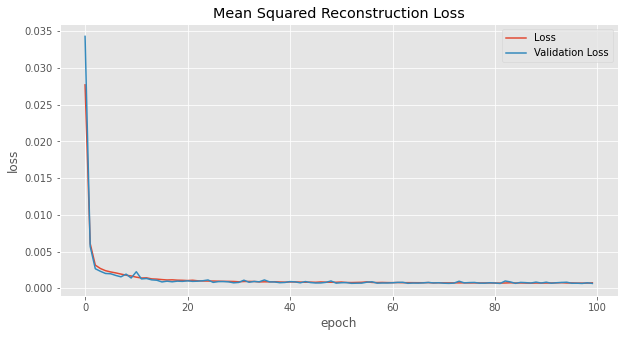

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Squared Reconstruction Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'])
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
X = latent_representations
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=7)
y_test_actual = scaler.inverse_transform(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RMSE of RF : 6.5133570980777575


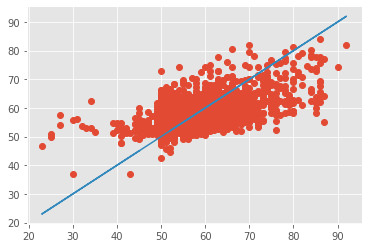

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
predictions = np.reshape(scaler.inverse_transform(np.expand_dims(y_pred,-1)),-1)

print("RMSE of RF :",np.sqrt(mean_squared_error( y_test_actual,predictions)))
plt.plot(y_test_actual,predictions,'o',y_test_actual,y_test_actual,'-');

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE of SVM : 6.452065152805216


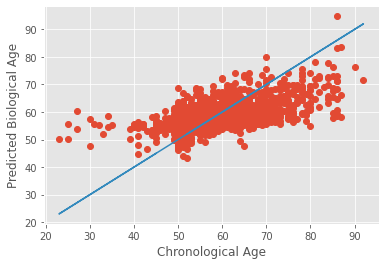

In [ ]:
from sklearn.svm import SVR
 
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
predictions = np.reshape(scaler.inverse_transform(np.expand_dims(y_pred,-1)),-1)
#y_pred = scaler_list[i].inverse_transform(y_pred_i)
print("RMSE of SVM :",np.sqrt(mean_squared_error(y_test_actual,predictions)))

plt.plot(y_test_actual,predictions,'o',y_test_actual,y_test_actual,'-');
plt.xlabel('Chronological Age');
plt.ylabel('Predicted Biological Age');